# *eht-imaging* tutorial #1

---

`eht-imaging` is a Python software for radio interferometric simulation, calibration, analysis, and imaging. 

Code and documentation can be found on [GitHub](https://github.com/achael/eht-imaging)

This notebook is an initial eht-imaging tutorial introducing data preparation, simulation, and Stokes I imaging. 

## Prerequisites
Running this notebook requires that `eht-imaging` and its dependencies are installed (see README on [GitHub](https://github.com/achael/eht-imaging)). If you do not have `nfft` installed, you can set `ttype=direct` or `ttype=fast` in the following.

In [698]:
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import ehtim as eh
import time
import os
from astropy.time import Time

plt.close('all')

# Fourier transform type - change this to 'direct' if 'nfft' is not installed!!!
ttype = 'nfft'

In [262]:
# create directory for results
outpath = './tutorial_results/ehtim_tutorial1'
if not os.path.exists(os.path.dirname(outpath)):
    os.makedirs(os.path.dirname(outpath))

## Load Image

In [699]:
# Load the image and the telescope array
im = eh.image.load_image('../models/jason_mad_eofn.txt')
im.mjd = Time.now().mjd
eht = eh.array.load_txt('../arrays/EHT2017_m87.txt')

Loading text image:  ../models/jason_mad_eofn.txt


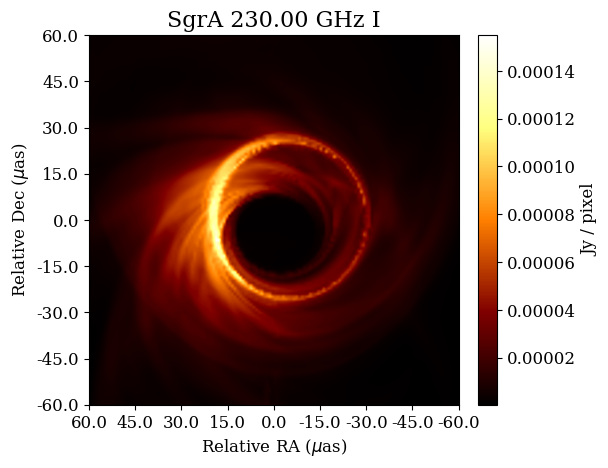

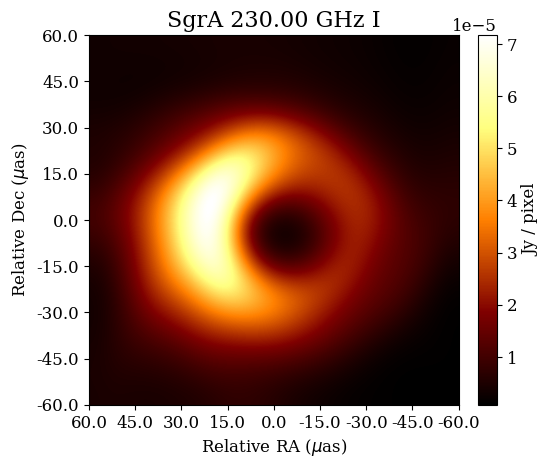

In [264]:
# Regrid the image for display
imdisp = im.regrid_image(120*eh.RADPERUAS, 512)

# Look at the image
imdisp.display();
imdisp.blur_circ(15*eh.RADPERUAS).display();

## Simulate an observation and plot data

In [707]:
# simulate and save an EHT observation
# ampcal and phasecal determine if gain variations and phase errors are included
# for now, let's assume we can calibrate both amplitude and phase
# try changing phasecal=False and see what happens!

# simulation parameters
tint_sec = 60  # Integration time in seconds, 
tadv_sec = 600 # Advance time between scans
tstart_hr = 0  # GMST time of the start of the observation
tstop_hr = 24  # GMST time of the end of the observation
bw_hz = 4.e9   # Bandwidth in Hz


# generate the observation
obs = im.observe(eht, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz,
                 sgrscat=False, ampcal=True, phasecal=True, add_th_noise=True)

# save the observation in a uvfits files 
obs.save_uvfits(outpath+'.uvfits')



Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Adding thermal noise to data . . . 
Building NX table


In [ ]:
import numpy as np
from astropy import units as u
from astropy.coordinates import EarthLocation
import matplotlib.pyplot as plt
# Generate n new telescopes either by finding the most isolated points or randomly
def generate_new_telescopes(eht_, n = 0, use_max_distance = False):
    new_telescopes = {}

    for i in range(n):
        # Earth's approximate radius in meters
        earth_radius = 6371000  # Average radius of Earth in meters

        if use_max_distance:
            max_distance = 0
            best_location = None

            # Iterate over a grid of potential locations (example: Earth's surface)
            for x in np.linspace(-7e6, 7e6, 50):  # Adjust grid range and resolution as needed
                for y in np.linspace(-7e6, 7e6, 50):
                    for z in np.linspace(-7e6, 7e6, 50):
                        candidate_location = np.array([x, y, z])

                    # Compute the distance of the candidate location from Earth's center
                        distance_from_center = np.linalg.norm(candidate_location)

                    # Skip locations that are not within 99%-101% of Earth's radius
                        if not (0.99 * earth_radius <= distance_from_center <= 1.01 * earth_radius):
                            continue

                    # Compute the minimum distance to all existing telescopes (including new ones)
                        min_distance = min(
                        np.linalg.norm(candidate_location - np.array([tel['x'], tel['y'], tel['z']]))
                        for tel in eht_.tarr
                    )
                        for _, location in new_telescopes.items():
                            min_distance = min(min_distance, np.linalg.norm(candidate_location - np.array([location.x.value, location.y.value, location.z.value])))

                    # Update the best location if this candidate is more isolated
                        if min_distance > max_distance:
                            max_distance = min_distance
                            best_location = candidate_location

        # Add the new telescope at the best location
            new_tel_name = f"NEW{i+1}"
            print(f"New Telescope: {new_tel_name}, Max Distance: {max_distance}, Best Location: {best_location}")
            new_telescopes[new_tel_name] = EarthLocation.from_geocentric(*best_location, unit=u.m)
        else:
        # Randomly generate a location on Earth's surface
            phi = np.random.uniform(0, 2 * np.pi)  # Longitude
            theta = np.random.uniform(0, np.pi)  # Colatitude
            x = earth_radius * np.sin(theta) * np.cos(phi)
            y = earth_radius * np.sin(theta) * np.sin(phi)
            z = earth_radius * np.cos(theta)

            random_location = np.array([x, y, z])
            new_tel_name = f"NEW{i+1}"
            print(f"New Telescope: {new_tel_name}, Random Location: {random_location}")
            new_telescopes[new_tel_name] = EarthLocation.from_geocentric(*random_location, unit=u.m)

# Save the new telescopes with the telescopes from the EHT array in a new file
    new_telescopes_file = '../arrays/new_telescopes.txt'
    with open(new_telescopes_file, 'w') as f:
        for tel_name, location in new_telescopes.items():
        # Write the new telescopes with default values for the additional columns
            f.write(f"{tel_name} {location.x.value} {location.y.value} {location.z.value} 0.0\n")
        for tel in eht_.tarr:
        # Write the existing telescopes with their full data
            f.write(f"{tel['site']} {tel['x']} {tel['y']} {tel['z']} {tel['sefdr']}\n")
# Load the new telescopes from the file
    eht2 = eh.array.load_txt('../arrays/new_telescopes.txt')

# Simulate the observation with the updated array
    superobs = im.observe(eht2, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz,
                      sgrscat=False, ampcal=True, phasecal=True, add_th_noise=True)
                          
    return superobs, eht2

superobs, eht2 = generate_new_telescopes(eht, n=0, use_max_distance=True)

# Loop through all pairs of telescopes in the array
def separate_obs(eht2):
    subobs_list = []
    subobs_names = []
    for ant1, ant2 in eht2.listbls():
    # Create a subarray with the current pair of telescopes
        subarray = eht2.make_subarray([ant1, ant2])
    
    # Simulate the observation for the subarray
        try:
            subobs = im.observe(subarray, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz,
                            no_elevcut_space=False, dcal=False, sgrscat=False, ampcal=True, phasecal=True, add_th_noise=True)
        
        # Append the subobs to the list if there are mutual visibilities
            name = f"{ant1}-{ant2}"
            subobs_list.append(subobs)
            subobs_names.append(name)
        except Exception as e:
            print(f"Skipping pair {ant1}-{ant2}: {e}")
    return subobs_list, subobs_names

subobs_list, subobs_names = separate_obs(eht2)

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + 

/tmp/ipykernel_8018/2983003279.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')  # Use a colormap with many distinct colors


loaded spacecraft ephemeris ../arrays/ephemeris/TESS
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Generating empty observation file . . . 
Skipping pair ALMA-GLT: No mutual visibilities in the specified time range!
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase e

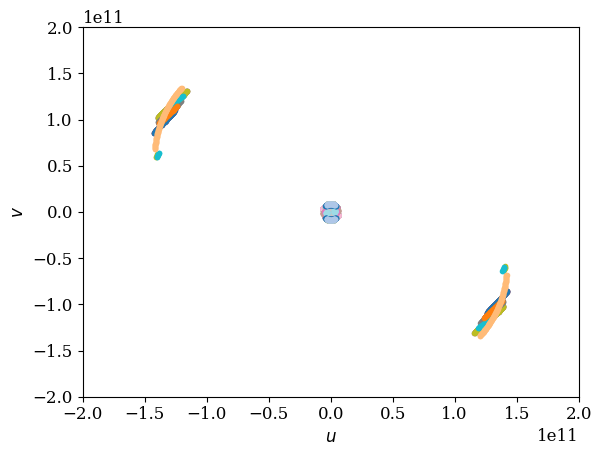

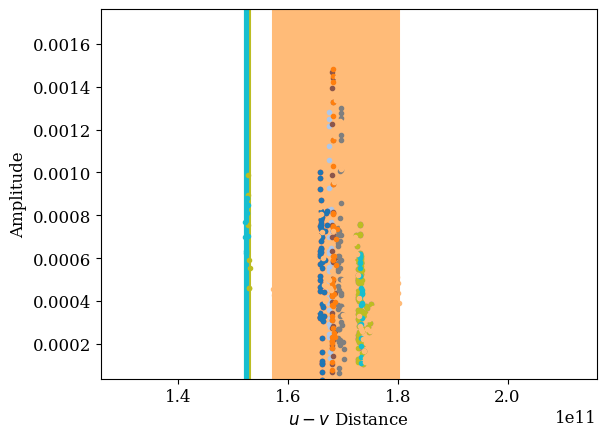

loaded spacecraft ephemeris ../arrays/ephemeris/ISS
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Generating empty observation file . . . 
Skipping pair ALMA-GLT: No mutual visibilities in the specified time range!
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase er

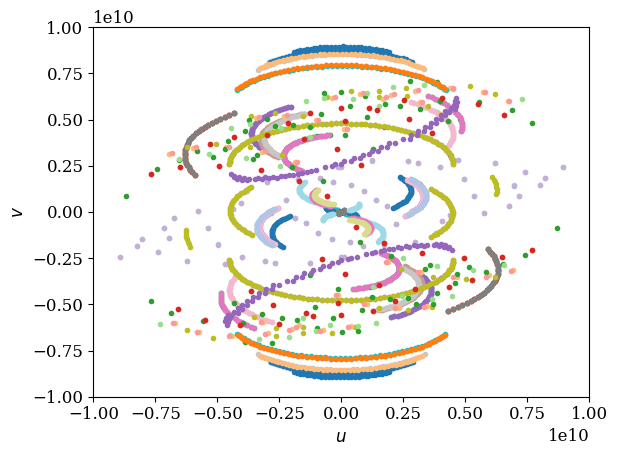

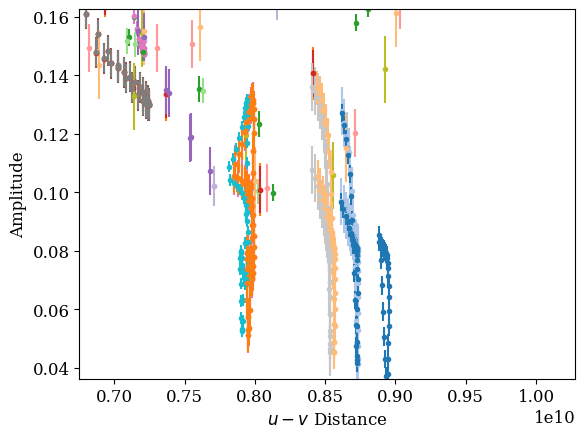

loaded spacecraft ephemeris ../arrays/ephemeris/TESS
loaded spacecraft ephemeris ../arrays/ephemeris/ISS
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Generating empty observation file . . . 
Skipping pair ALMA-GLT: No mutual visibilities in the specified time range!
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Generating empty observation file . . . 
Producing clean visibilities 

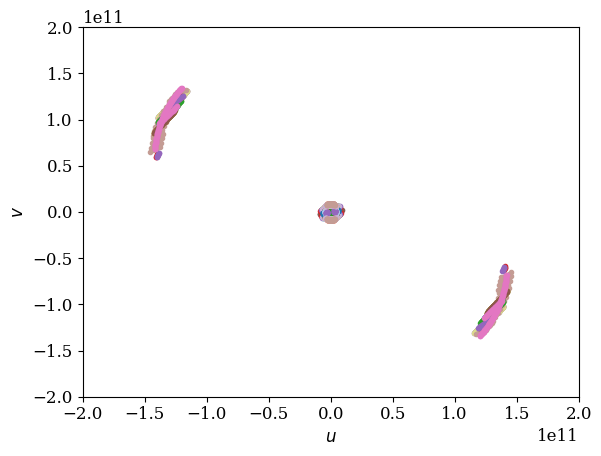

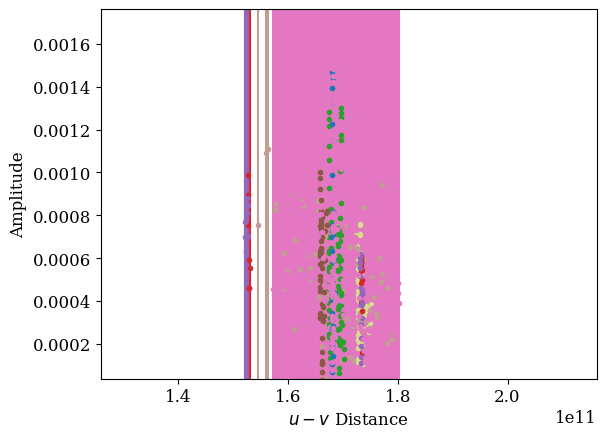

In [706]:
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex

# Generate a unique color for each sub-observation
cmap = get_cmap('tab20')  # Use a colormap with many distinct colors
colors = [to_hex(cmap(i / len(subobs_list))) for i in range(len(subobs_list))]

tess_array = eh.array.load_txt('../arrays/EHT2025wTESS.txt')
satellite_obs_tess = im.observe(tess_array, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz,
                                no_elevcut_space=False, dcal=False, sgrscat=False, ampcal=True, phasecal=True, add_th_noise=True)

satellite_obs_tess_list, satellite_obs_tess_names = separate_obs(tess_array)
eh.plotall_obs_compare(satellite_obs_tess_list, 'u', 'v', conj=True, rangey=[-2.e11, 2.e11], rangex=[-2.e11, 2.e11], clist=colors, legendlabels=satellite_obs_tess_names, legend=False)
ax=eh.plotall_obs_compare(satellite_obs_tess_list, 'uvdist', 'amp', clist=colors, legendlabels=satellite_obs_tess_names, legend=False)
ax.set_yscale('log')

iss_array = eh.array.load_txt('../arrays/EHT2025wISS.txt')
satellite_obs_iss = im.observe(iss_array, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz,
                                no_elevcut_space=False, dcal=False, sgrscat=False, ampcal=True, phasecal=True, add_th_noise=True)
satellite_obs_iss_list, satellite_obs_iss_names = separate_obs(iss_array)
eh.plotall_obs_compare(satellite_obs_iss_list, 'u', 'v', conj=True, rangey=[-1.e10, 1.e10], rangex=[-1.e10, 1.e10], clist=colors, legendlabels=satellite_obs_iss_names, legend=False)
ax2=eh.plotall_obs_compare(satellite_obs_iss_list, 'uvdist', 'amp', clist=colors, legendlabels=satellite_obs_iss_names, legend=False)
ax2.set_yscale('log')
# Combine the normal array with TESS and ISS
tess_iss_combined_array_file = '../arrays/EHT2025wTESS_ISS.txt'
with open(tess_iss_combined_array_file, 'w') as f:
    unique_sites = set()
    # Write normal array data
    for tel in eht.tarr:
        if tel['site'] not in unique_sites:
            unique_sites.add(tel['site'])
            f.write(f"{tel['site']} {tel['x']} {tel['y']} {tel['z']} {tel['sefdr']}\n")
    # Write TESS array data
    for tel in tess_array.tarr:
        if tel['site'] not in unique_sites:
            unique_sites.add(tel['site'])
            f.write(f"{tel['site']} {tel['x']} {tel['y']} {tel['z']} {tel['sefdr']}\n")
    # Write ISS array data
    for tel in iss_array.tarr:
        if tel['site'] not in unique_sites:
            unique_sites.add(tel['site'])
            f.write(f"{tel['site']} {tel['x']} {tel['y']} {tel['z']} {tel['sefdr']}\n")

tess_iss_combined_array = eh.array.load_txt(tess_iss_combined_array_file)
satellite_obs_tess_iss = im.observe(tess_iss_combined_array, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz,
                                no_elevcut_space=False, dcal=False, sgrscat=False, ampcal=True, phasecal=True, add_th_noise=True)

satellite_obs_tess_iss_list, satellite_obs_tess_iss_names = separate_obs(tess_iss_combined_array)
eh.plotall_obs_compare(satellite_obs_tess_iss_list, 'u', 'v', conj=True, rangey=[-2.e11, 2.e11], rangex=[-2.e11, 2.e11], clist=colors, legendlabels=satellite_obs_tess_iss_names, legend=False)
ax3=eh.plotall_obs_compare(satellite_obs_tess_iss_list, 'uvdist', 'amp', clist=colors, legendlabels=satellite_obs_tess_iss_names, legend=False)
ax3.set_yscale('log')

New Telescope: NEW1, Max Distance: 9542469.170353169, Best Location: [-1571428.57142857  6142857.14285714  1000000.        ]
Generating empty observation file . . . 
Warning!: in make_uvpoints, some SEFDs are <= 0!
Warning!: in make_uvpoints, some SEFDs are <= 0!
Warning!: in make_uvpoints, some SEFDs are <= 0!
Warning!: in make_uvpoints, some SEFDs are <= 0!
Warning!: in make_uvpoints, some SEFDs are <= 0!
Warning!: in make_uvpoints, some SEFDs are <= 0!
Warning!: in make_uvpoints, some SEFDs are <= 0!
Warning!: in make_uvpoints, some SEFDs are <= 0!
Warning!: in make_uvpoints, some SEFDs are <= 0!
Warning!: in make_uvpoints, some SEFDs are <= 0!
Warning!: in make_uvpoints, some SEFDs are <= 0!
Warning!: in make_uvpoints, some SEFDs are <= 0!
Warning!: in make_uvpoints, some SEFDs are <= 0!
Warning!: in make_uvpoints, some SEFDs are <= 0!
Warning!: in make_uvpoints, some SEFDs are <= 0!
Warning!: in make_uvpoints, some SEFDs are <= 0!
Warning!: in make_uvpoints, some SEFDs are <= 0!
W

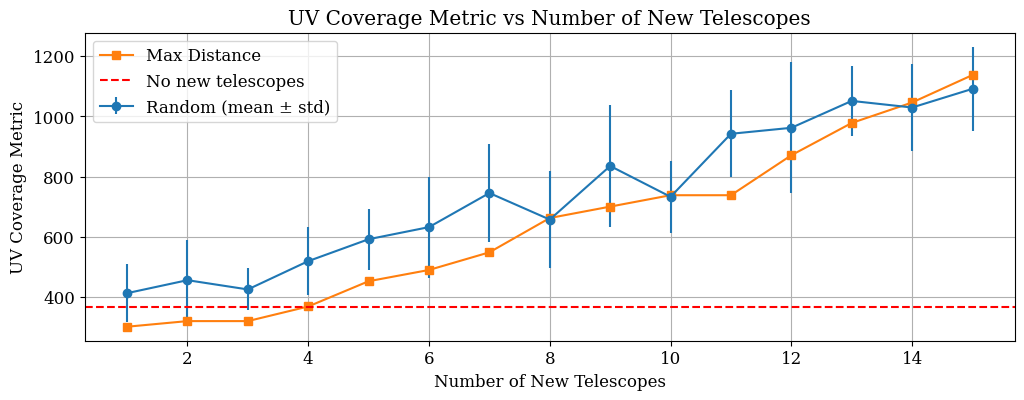

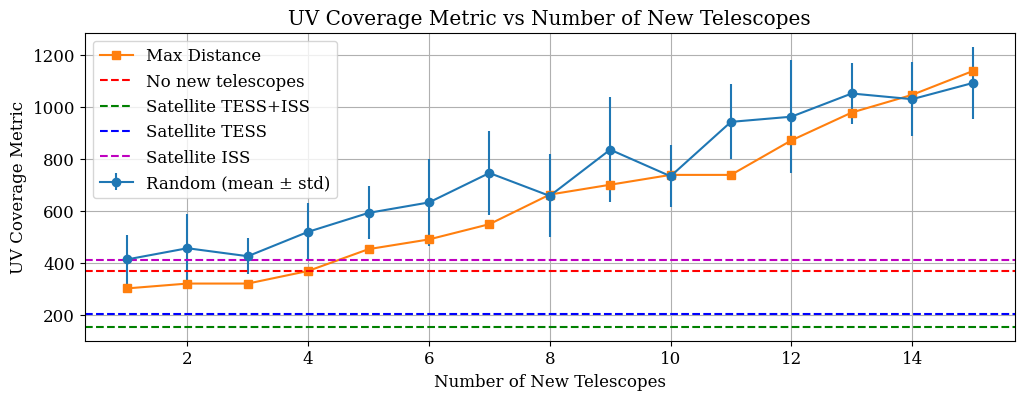

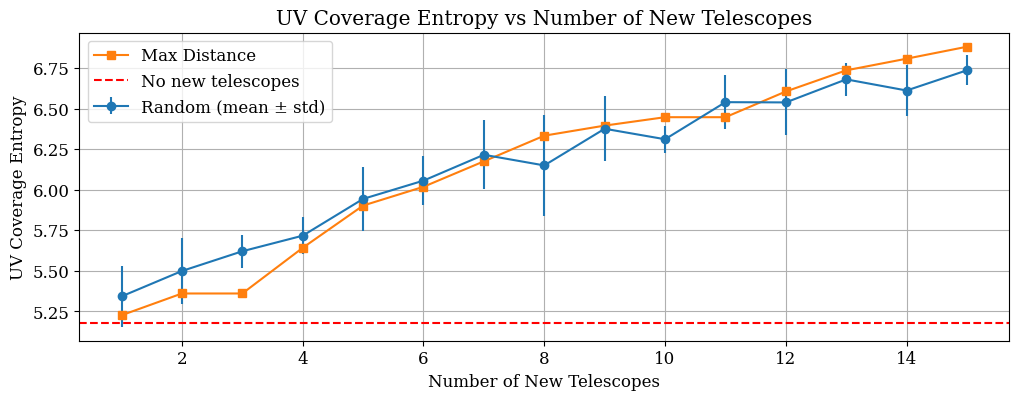

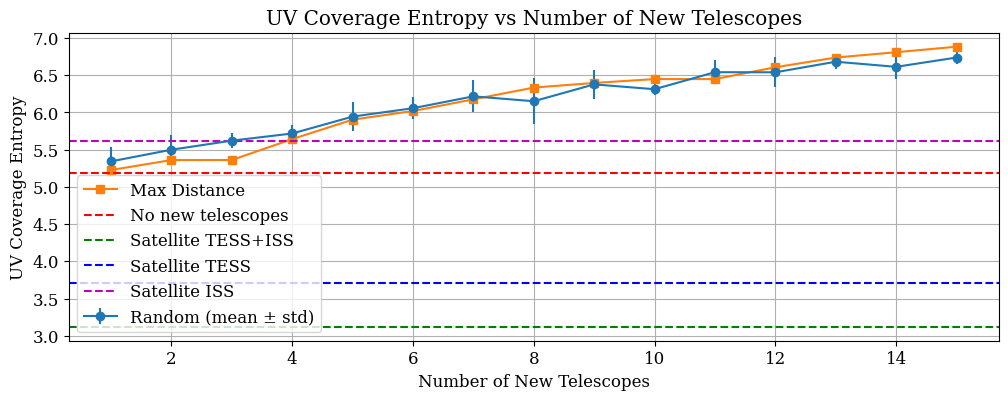

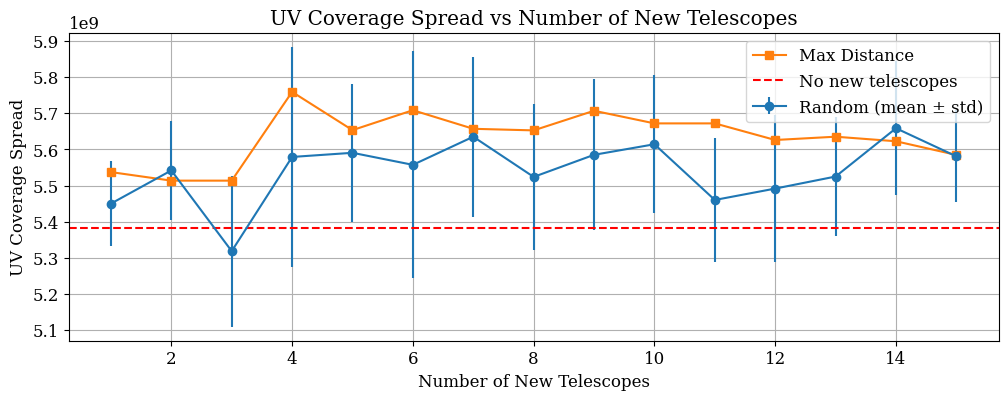

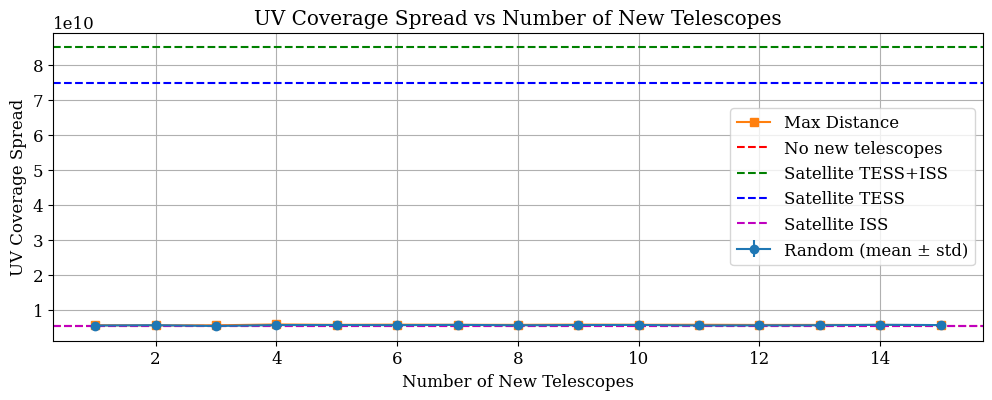

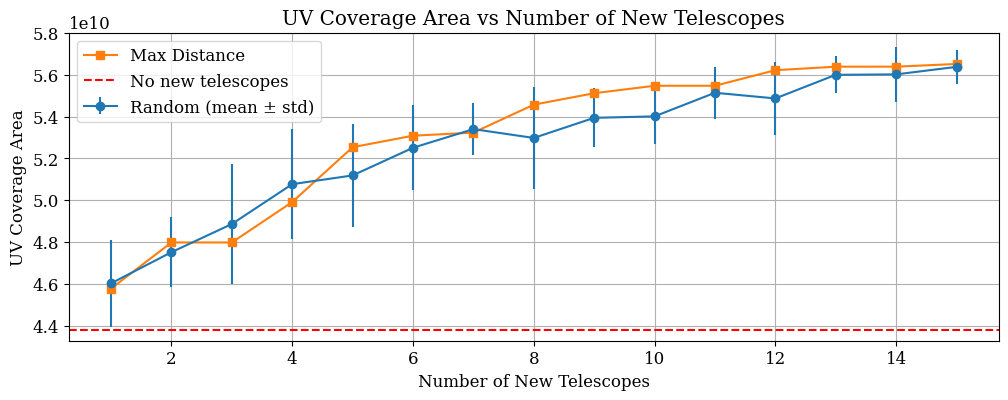

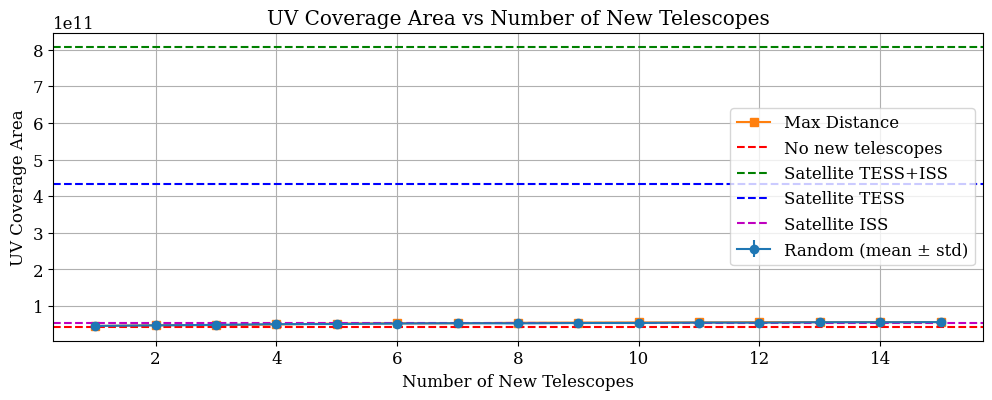

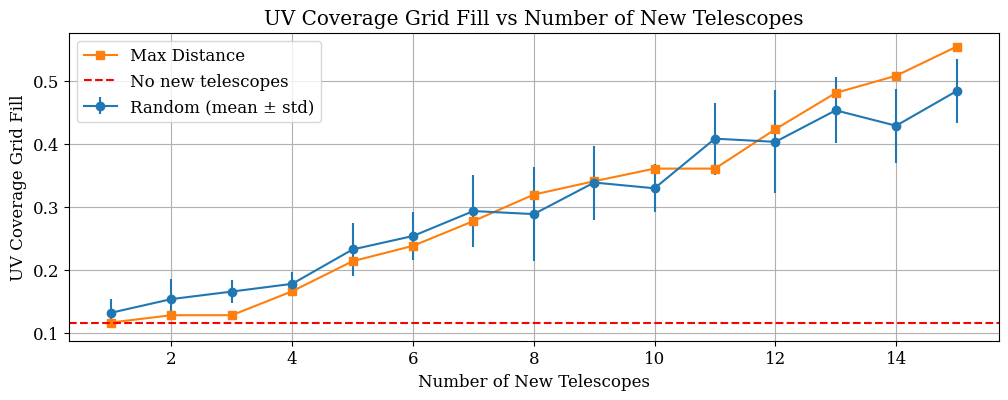

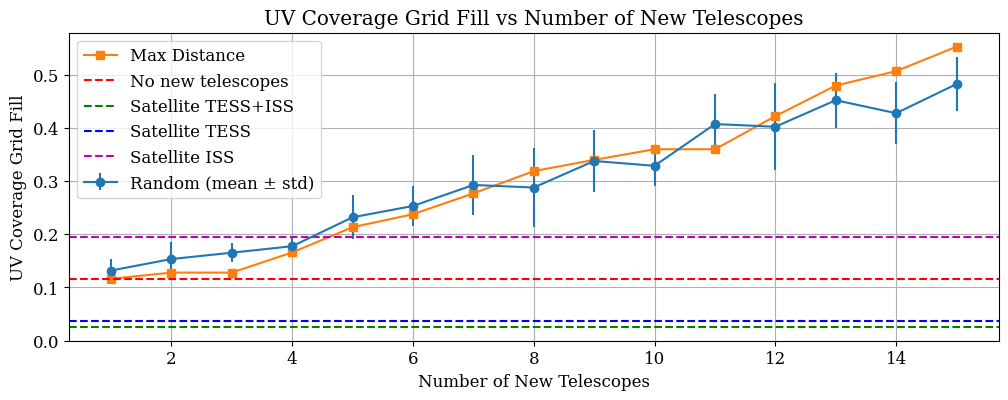

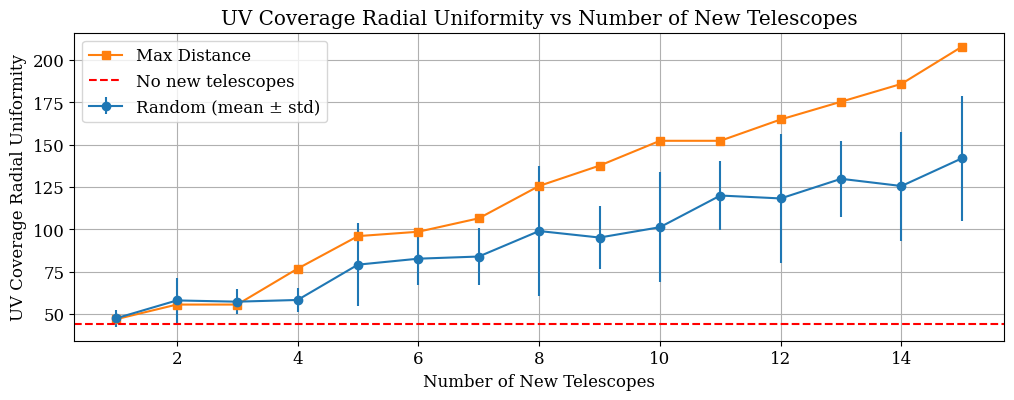

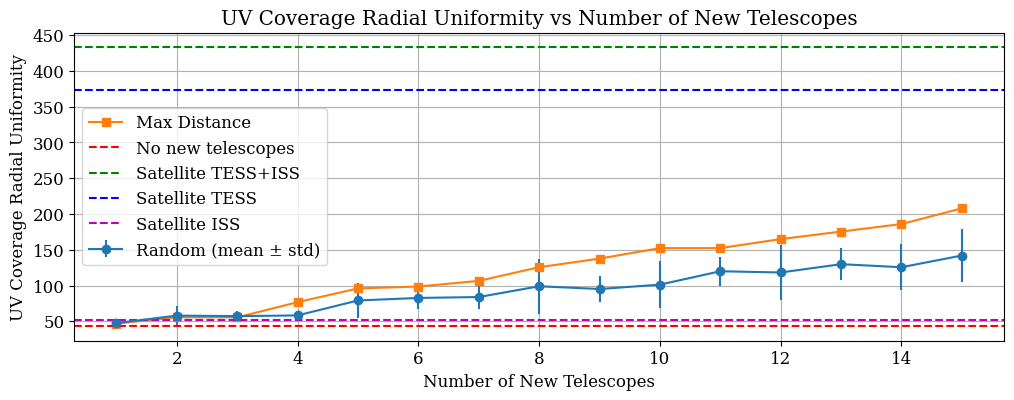

In [704]:
from scipy.spatial import ConvexHull
from matplotlib.ticker import FuncFormatter

def calculate_uv_coverage_metric(obsdata):
    """
    Calculate a metric for UV coverage based on the density and uniformity of UV points.
    A higher value indicates better coverage but not necessarily uniformity.
    """
    # Extract UV coordinates
    u_coords = obsdata.data['u']
    v_coords = obsdata.data['v']

    # Calculate the density of UV points
    uv_density = len(u_coords) / (np.max(u_coords) - np.min(u_coords)) * (np.max(v_coords) - np.min(v_coords))

    # Calculate the uniformity of UV coverage using a histogram
    hist, _, _ = np.histogram2d(u_coords, v_coords, bins=50)
    uniformity = np.std(hist)  # Standard deviation of the histogram (lower is better)

    # Combine density and uniformity into a single metric
    metric = uv_density / (1 + uniformity)
    return metric

def calculate_uv_coverage_entropy(obsdata):
    """
    Calculate a UV coverage metric based on the entropy of the UV point distribution.
    A lower entropy indicates more concentrated coverage, while higher entropy indicates more uniform coverage.
    """
    # Extract UV coordinates
    u_coords = obsdata.data['u']
    v_coords = obsdata.data['v']

    # Create a 2D histogram of UV points
    hist, _, _ = np.histogram2d(u_coords, v_coords, bins=50)

    # Normalize the histogram to create a probability distribution
    hist_prob = hist / np.sum(hist)

    # Calculate the entropy of the distribution
    entropy = -np.nansum(hist_prob * np.log(hist_prob + 1e-10))  # Add small value to avoid log(0)

    return entropy

def calculate_uv_coverage_spread(obsdata):
    """
    Calculate a UV coverage metric based on the spread of UV points.
    A higher spread indicates better coverage across the UV plane.
    """
    # Extract UV coordinates
    u_coords = obsdata.data['u']
    v_coords = obsdata.data['v']

    # Calculate the mean and standard deviation of UV coordinates
    u_mean = np.mean(u_coords)
    v_mean = np.mean(v_coords)
    u_std = np.std(u_coords)
    v_std = np.std(v_coords)

    # Combine the standard deviations to represent the spread
    spread_metric = np.sqrt(u_std**2 + v_std**2)

    return spread_metric

def calculate_uv_coverage_area(obsdata):
    """
    Calculate a UV coverage metric based on the convex hull area of UV points.
    A larger area indicates better coverage across the UV plane.
    """

    # Extract UV coordinates
    u_coords = obsdata.data['u']
    v_coords = obsdata.data['v']

    # Combine UV coordinates into a single array
    uv_points = np.column_stack((u_coords, v_coords))

    # Calculate the convex hull area
    try:
        hull = ConvexHull(uv_points)
        area = hull.area
    except Exception as e:
        print(f"Error calculating convex hull: {e}")
        area = 0  # Default to 0 if convex hull cannot be calculated

    return area

def calculate_uv_coverage_grid_fill(obsdata, nbins=50):
    """
    Calculate a UV coverage metric based on the grid filling factor.
    The u–v plane is divided into an nbins×nbins grid, and the metric
    is the fraction of grid cells containing at least one UV sample.
    A higher value indicates more complete coverage.
    """
    # Extract UV coordinates
    u_coords = obsdata.data['u']
    v_coords = obsdata.data['v']

    # Create 2D histogram bins edges
    u_edges = np.linspace(u_coords.min(), u_coords.max(), nbins + 1)
    v_edges = np.linspace(v_coords.min(), v_coords.max(), nbins + 1)
    
    # Compute the 2D histogram
    hist, _, _ = np.histogram2d(u_coords, v_coords, bins=[u_edges, v_edges])
    
    # Count non-empty cells
    filled_cells = np.count_nonzero(hist)
    total_cells = nbins * nbins
    
    # Grid filling factor
    grid_fill_metric = filled_cells / total_cells
    
    return grid_fill_metric

def calculate_uv_coverage_radial_uniformity(obsdata, nbins=20):
    """
    Calculate a UV coverage metric based on radial coverage uniformity.
    UV samples are binned by their radial distance from the origin into
    nbins rings; the metric is the standard deviation of counts across bins
    (lower is better uniformity).
    """
    # Extract UV coordinates and compute radial distances
    u_coords = obsdata.data['u']
    v_coords = obsdata.data['v']
    radial_dist = np.sqrt(u_coords**2 + v_coords**2)
    
    # Define radial bins
    r_edges = np.linspace(radial_dist.min(), radial_dist.max(), nbins + 1)
    
    # Bin samples by radial distance
    counts, _ = np.histogram(radial_dist, bins=r_edges)
    
    # Compute standard deviation of bin counts
    radial_uniformity_metric = np.std(counts)
    
    return radial_uniformity_metric

# Initialize arrays to store results
metrics_max_distance = []
metrics_random = []
entropies_max_distance = []
entropies_random = []
spreads_max_distance = []
spreads_random = []
areas_max_distance = []
areas_random = []
grid_fills_max_distance = []
grid_fills_random = []
radial_uniformities_max_distance = []
radial_uniformities_random = []

num_telescopes = 15  # Number of new telescopes to generate

# Calculate metrics for the existing 'obs' observations
original_metric = calculate_uv_coverage_metric(obs)
original_entropy = calculate_uv_coverage_entropy(obs)
original_spread = calculate_uv_coverage_spread(obs)
original_area = calculate_uv_coverage_area(obs)
original_grid_fill = calculate_uv_coverage_grid_fill(obs)
original_radial_uniformity = calculate_uv_coverage_radial_uniformity(obs)

# Calculate metrics for the satellite observations
satellite_tess_iss_metric = calculate_uv_coverage_metric(satellite_obs_tess_iss)
satellite_tess_metric = calculate_uv_coverage_metric(satellite_obs_tess)
satellite_iss_metric = calculate_uv_coverage_metric(satellite_obs_iss)

satellite_tess_iss_entropy = calculate_uv_coverage_entropy(satellite_obs_tess_iss)
satellite_tess_entropy = calculate_uv_coverage_entropy(satellite_obs_tess)
satellite_iss_entropy = calculate_uv_coverage_entropy(satellite_obs_iss)

satellite_tess_iss_spread = calculate_uv_coverage_spread(satellite_obs_tess_iss)
satellite_tess_spread = calculate_uv_coverage_spread(satellite_obs_tess)
satellite_iss_spread = calculate_uv_coverage_spread(satellite_obs_iss)

satellite_tess_iss_area = calculate_uv_coverage_area(satellite_obs_tess_iss)
satellite_tess_area = calculate_uv_coverage_area(satellite_obs_tess)
satellite_iss_area = calculate_uv_coverage_area(satellite_obs_iss)

satellite_tess_iss_grid_fill = calculate_uv_coverage_grid_fill(satellite_obs_tess_iss)
satellite_tess_grid_fill = calculate_uv_coverage_grid_fill(satellite_obs_tess)
satellite_iss_grid_fill = calculate_uv_coverage_grid_fill(satellite_obs_iss)

satellite_tess_iss_radial_uniformity = calculate_uv_coverage_radial_uniformity(satellite_obs_tess_iss)
satellite_tess_radial_uniformity = calculate_uv_coverage_radial_uniformity(satellite_obs_tess)
satellite_iss_radial_uniformity = calculate_uv_coverage_radial_uniformity(satellite_obs_iss)


# Loop over the number of new telescopes (1 to 10)
for n_telescopes in range(1, num_telescopes+1):
    # Generate telescopes using use_max_distance=True
    superobs_max, _ = generate_new_telescopes(eht, n=n_telescopes, use_max_distance=True)
    metric_max = calculate_uv_coverage_metric(superobs_max)
    entropy_max = calculate_uv_coverage_entropy(superobs_max)
    spread_max = calculate_uv_coverage_spread(superobs_max)
    area_max = calculate_uv_coverage_area(superobs_max)
    grid_fill_max = calculate_uv_coverage_grid_fill(superobs_max)
    radial_uniformity_max = calculate_uv_coverage_radial_uniformity(superobs_max)
    metrics_max_distance.append(metric_max)
    entropies_max_distance.append(entropy_max)
    spreads_max_distance.append(spread_max)
    areas_max_distance.append(area_max)
    grid_fills_max_distance.append(grid_fill_max)
    radial_uniformities_max_distance.append(radial_uniformity_max)

    # Generate telescopes using use_max_distance=False (10 trials)
    random_metrics = []
    random_entropies = []
    random_spreads = []
    random_areas = []
    random_grid_fills = []
    random_radial_uniformities = []
    for _ in range(10):
        superobs_random, _ = generate_new_telescopes(eht, n=n_telescopes, use_max_distance=False)
        random_metrics.append(calculate_uv_coverage_metric(superobs_random))
        random_entropies.append(calculate_uv_coverage_entropy(superobs_random))
        random_spreads.append(calculate_uv_coverage_spread(superobs_random))
        random_areas.append(calculate_uv_coverage_area(superobs_random))
        random_grid_fills.append(calculate_uv_coverage_grid_fill(superobs_random))
        random_radial_uniformities.append(calculate_uv_coverage_radial_uniformity(superobs_random))

    # Store the mean and standard deviation for random results
    metrics_random.append((np.mean(random_metrics), np.std(random_metrics)))
    entropies_random.append((np.mean(random_entropies), np.std(random_entropies)))
    spreads_random.append((np.mean(random_spreads), np.std(random_spreads)))
    areas_random.append((np.mean(random_areas), np.std(random_areas)))
    grid_fills_random.append((np.mean(random_grid_fills), np.std(random_grid_fills)))
    radial_uniformities_random.append((np.mean(random_radial_uniformities), np.std(random_radial_uniformities)))

# Plot the results
x = range(1, len(metrics_max_distance) + 1)

# Plot UV coverage metric
plt.figure(figsize=(12, 4))
plt.errorbar(range(1, num_telescopes+1), [m[0] for m in metrics_random], yerr=[m[1] for m in metrics_random], fmt='o-', label='Random (mean ± std)')
plt.plot(x, metrics_max_distance, 's-', label='Max Distance')
plt.axhline(y=original_metric, color='r', linestyle='--', label='No new telescopes')
plt.xlabel('Number of New Telescopes')
plt.ylabel('UV Coverage Metric')
plt.title('UV Coverage Metric vs Number of New Telescopes')
plt.legend()
plt.grid()

# Plot UV coverage metric
plt.figure(figsize=(12, 4))
plt.errorbar(range(1, num_telescopes+1), [m[0] for m in metrics_random], yerr=[m[1] for m in metrics_random], fmt='o-', label='Random (mean ± std)')
plt.plot(x, metrics_max_distance, 's-', label='Max Distance')
plt.axhline(y=original_metric, color='r', linestyle='--', label='No new telescopes')
plt.axhline(y=satellite_tess_iss_metric, color='g', linestyle='--', label='Satellite TESS+ISS')
plt.axhline(y=satellite_tess_metric, color='b', linestyle='--', label='Satellite TESS')
plt.axhline(y=satellite_iss_metric, color='m', linestyle='--', label='Satellite ISS')
#plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xlabel('Number of New Telescopes')
plt.ylabel('UV Coverage Metric')
plt.title('UV Coverage Metric vs Number of New Telescopes')
plt.legend()
plt.grid()

# Plot UV coverage entropy
plt.figure(figsize=(12, 4))
plt.errorbar(range(1, num_telescopes+1), [e[0] for e in entropies_random], yerr=[e[1] for e in entropies_random], fmt='o-', label='Random (mean ± std)')
plt.plot(x, entropies_max_distance, 's-', label='Max Distance')
plt.axhline(y=original_entropy, color='r', linestyle='--', label='No new telescopes')
plt.xlabel('Number of New Telescopes')
plt.ylabel('UV Coverage Entropy')
plt.title('UV Coverage Entropy vs Number of New Telescopes')
plt.legend()
plt.grid()

# Plot UV coverage entropy
plt.figure(figsize=(12, 4))
plt.errorbar(range(1, num_telescopes+1), [e[0] for e in entropies_random], yerr=[e[1] for e in entropies_random], fmt='o-', label='Random (mean ± std)')
plt.plot(x, entropies_max_distance, 's-', label='Max Distance')
plt.axhline(y=original_entropy, color='r', linestyle='--', label='No new telescopes')
plt.axhline(y=satellite_tess_iss_entropy, color='g', linestyle='--', label='Satellite TESS+ISS')
plt.axhline(y=satellite_tess_entropy, color='b', linestyle='--', label='Satellite TESS')
plt.axhline(y=satellite_iss_entropy, color='m', linestyle='--', label='Satellite ISS')
#plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xlabel('Number of New Telescopes')
plt.ylabel('UV Coverage Entropy')
plt.title('UV Coverage Entropy vs Number of New Telescopes')
plt.legend()
plt.grid()

# Plot UV coverage spread
plt.figure(figsize=(12, 4))
plt.errorbar(range(1, num_telescopes+1), [s[0] for s in spreads_random], yerr=[s[1] for s in spreads_random], fmt='o-', label='Random (mean ± std)')
plt.plot(x, spreads_max_distance, 's-', label='Max Distance')
plt.axhline(y=original_spread, color='r', linestyle='--', label='No new telescopes')
plt.xlabel('Number of New Telescopes')
plt.ylabel('UV Coverage Spread')
plt.title('UV Coverage Spread vs Number of New Telescopes')
plt.legend()
plt.grid()

# Plot UV coverage spread
plt.figure(figsize=(12, 4))
plt.errorbar(range(1, num_telescopes+1), [s[0] for s in spreads_random], yerr=[s[1] for s in spreads_random], fmt='o-', label='Random (mean ± std)')
plt.plot(x, spreads_max_distance, 's-', label='Max Distance')
plt.axhline(y=original_spread, color='r', linestyle='--', label='No new telescopes')
plt.axhline(y=satellite_tess_iss_spread, color='g', linestyle='--', label='Satellite TESS+ISS')
plt.axhline(y=satellite_tess_spread, color='b', linestyle='--', label='Satellite TESS')
plt.axhline(y=satellite_iss_spread, color='m', linestyle='--', label='Satellite ISS')
#plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xlabel('Number of New Telescopes')
plt.ylabel('UV Coverage Spread')
plt.title('UV Coverage Spread vs Number of New Telescopes')
plt.legend()
plt.grid()

# Plot UV coverage area
plt.figure(figsize=(12, 4))
plt.errorbar(range(1, num_telescopes+1), [a[0] for a in areas_random], yerr=[a[1] for a in areas_random], fmt='o-', label='Random (mean ± std)')
plt.plot(x, areas_max_distance, 's-', label='Max Distance')
plt.axhline(y=original_area, color='r', linestyle='--', label='No new telescopes')
plt.xlabel('Number of New Telescopes')
plt.ylabel('UV Coverage Area')
plt.title('UV Coverage Area vs Number of New Telescopes')
plt.legend()
plt.grid()

# Plot UV coverage area
plt.figure(figsize=(12, 4))
plt.errorbar(range(1, num_telescopes+1), [a[0] for a in areas_random], yerr=[a[1] for a in areas_random], fmt='o-', label='Random (mean ± std)')
plt.plot(x, areas_max_distance, 's-', label='Max Distance')
plt.axhline(y=original_area, color='r', linestyle='--', label='No new telescopes')
plt.axhline(y=satellite_tess_iss_area, color='g', linestyle='--', label='Satellite TESS+ISS')
plt.axhline(y=satellite_tess_area, color='b', linestyle='--', label='Satellite TESS')
plt.axhline(y=satellite_iss_area, color='m', linestyle='--', label='Satellite ISS')
#plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xlabel('Number of New Telescopes')
plt.ylabel('UV Coverage Area')
plt.title('UV Coverage Area vs Number of New Telescopes')
plt.legend()
plt.grid()

# Plot UV coverage grid fill
plt.figure(figsize=(12, 4))
plt.errorbar(range(1, num_telescopes+1), [g[0] for g in grid_fills_random], yerr=[g[1] for g in grid_fills_random], fmt='o-', label='Random (mean ± std)')
plt.plot(x, grid_fills_max_distance, 's-', label='Max Distance')
plt.axhline(y=original_grid_fill, color='r', linestyle='--', label='No new telescopes')
plt.xlabel('Number of New Telescopes')
plt.ylabel('UV Coverage Grid Fill')
plt.title('UV Coverage Grid Fill vs Number of New Telescopes')
plt.legend()
plt.grid()

# Plot UV coverage grid fill
plt.figure(figsize=(12, 4))
plt.errorbar(range(1, num_telescopes+1), [g[0] for g in grid_fills_random], yerr=[g[1] for g in grid_fills_random], fmt='o-', label='Random (mean ± std)')
plt.plot(x, grid_fills_max_distance, 's-', label='Max Distance')
plt.axhline(y=original_grid_fill, color='r', linestyle='--', label='No new telescopes')
plt.axhline(y=satellite_tess_iss_grid_fill, color='g', linestyle='--', label='Satellite TESS+ISS')
plt.axhline(y=satellite_tess_grid_fill, color='b', linestyle='--', label='Satellite TESS')
plt.axhline(y=satellite_iss_grid_fill, color='m', linestyle='--', label='Satellite ISS')
#plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xlabel('Number of New Telescopes')
plt.ylabel('UV Coverage Grid Fill')
plt.title('UV Coverage Grid Fill vs Number of New Telescopes')
plt.legend()
plt.grid()

# Plot UV coverage radial uniformity
plt.figure(figsize=(12, 4))
plt.errorbar(range(1, num_telescopes+1), [r[0] for r in radial_uniformities_random], yerr=[r[1] for r in radial_uniformities_random], fmt='o-', label='Random (mean ± std)')
plt.plot(x, radial_uniformities_max_distance, 's-', label='Max Distance')
plt.axhline(y=original_radial_uniformity, color='r', linestyle='--', label='No new telescopes')
plt.xlabel('Number of New Telescopes')
plt.ylabel('UV Coverage Radial Uniformity')
plt.title('UV Coverage Radial Uniformity vs Number of New Telescopes')
plt.legend()
plt.grid()


# Plot UV coverage radial uniformity
plt.figure(figsize=(12, 4))
plt.errorbar(range(1, num_telescopes+1), [r[0] for r in radial_uniformities_random], yerr=[r[1] for r in radial_uniformities_random], fmt='o-', label='Random (mean ± std)')
plt.plot(x, radial_uniformities_max_distance, 's-', label='Max Distance')
plt.axhline(y=original_radial_uniformity, color='r', linestyle='--', label='No new telescopes')
plt.axhline(y=satellite_tess_iss_radial_uniformity, color='g', linestyle='--', label='Satellite TESS+ISS')
plt.axhline(y=satellite_tess_radial_uniformity, color='b', linestyle='--', label='Satellite TESS')
plt.axhline(y=satellite_iss_radial_uniformity, color='m', linestyle='--', label='Satellite ISS')

# def custom_scale(y, pos):
#     if y < 100:
#         return f"{y:.0f}"
#     else:
#         return f"{y:.0e}"
# plt.gca().yaxis.set_major_formatter(FuncFormatter(custom_scale))

plt.xlabel('Number of New Telescopes')
plt.ylabel('UV Coverage Radial Uniformity')
plt.title('UV Coverage Radial Uniformity vs Number of New Telescopes')
plt.legend()
plt.grid()

plt.show()


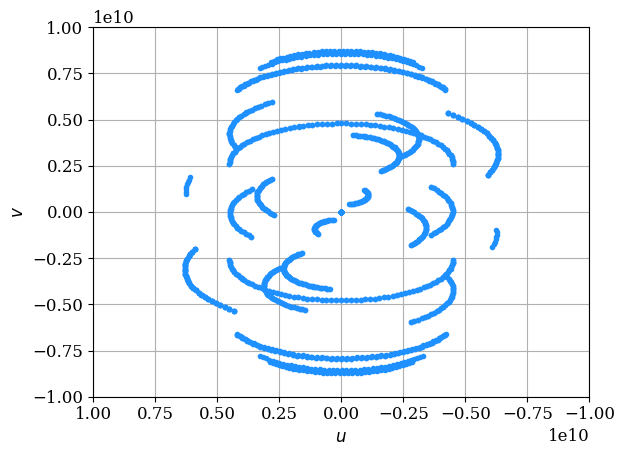

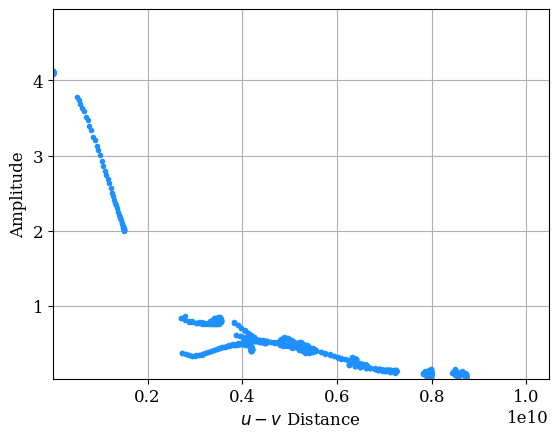

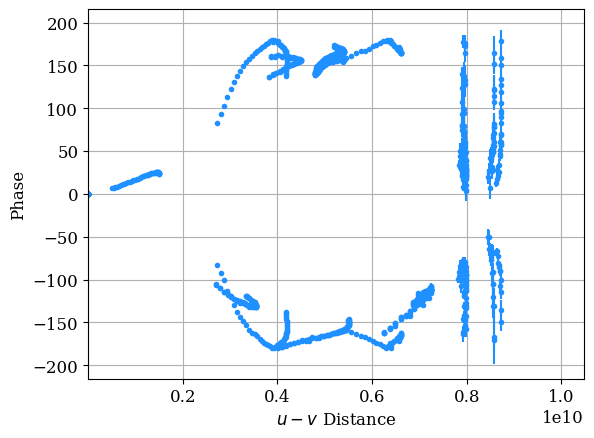

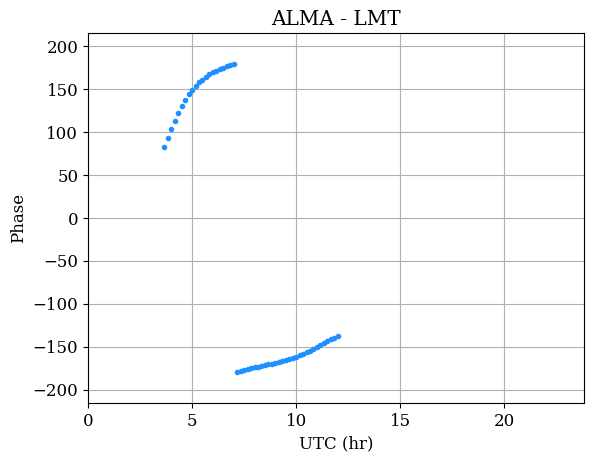

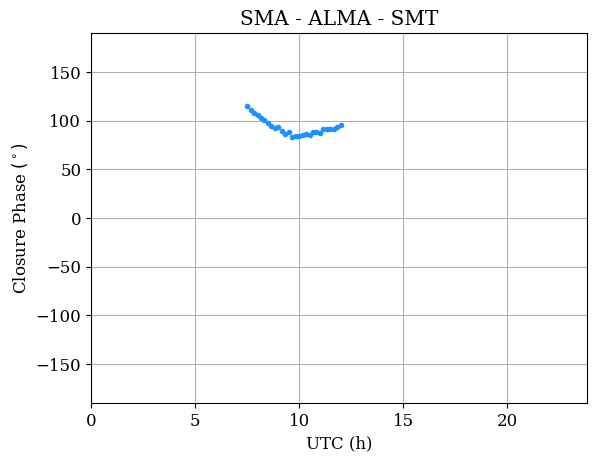

In [708]:
# Plot uv coverage
obs.plotall('u','v', conj=True, rangex=[1.e10,-1.e10],rangey=[-1.e10,1.e10]) 

# Plot amplitude with baseline distance
obs.plotall('uvdist','amp')  

# Plot phase with baseline distance'
obs.plotall('uvdist','phase') 

# Plot visibility phase on a baseline over time 
obs.plot_bl('ALMA','LMT','phase') 

# Plot closure phase on a triangle over time
obs.plot_cphase('SMA','ALMA','SMT'); 

/tmp/ipykernel_8018/4103837587.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')  # Use a colormap with many distinct colors


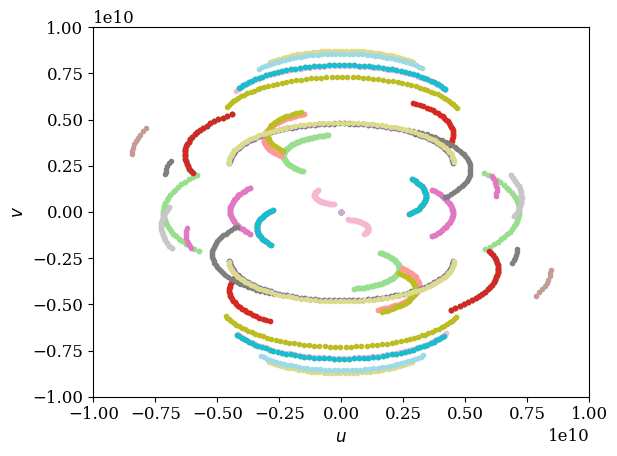

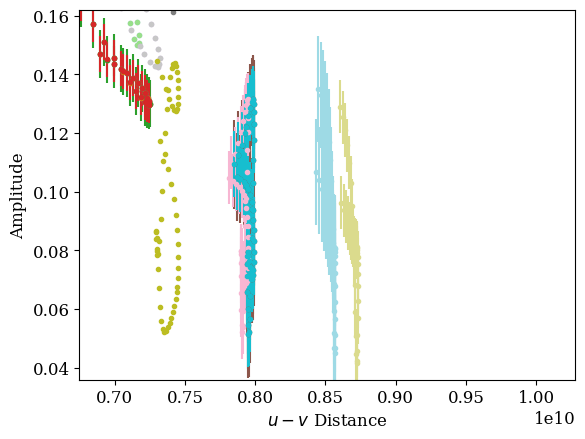

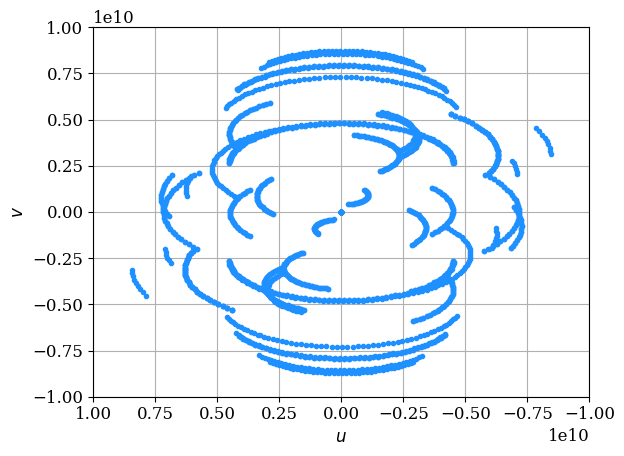

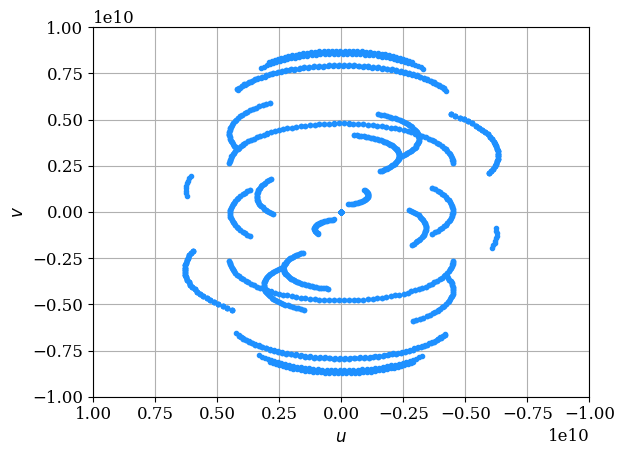

<Axes: xlabel='$u$', ylabel='$v$'>

In [430]:
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex

# Generate a unique color for each sub-observation
cmap = get_cmap('tab20')  # Use a colormap with many distinct colors
colors = [to_hex(cmap(i / len(subobs_list))) for i in range(len(subobs_list))]

# Plot with unique colors for each sub-observation
eh.plotall_obs_compare(subobs_list, 'u', 'v', conj=True, rangey=[-1.e10, 1.e10], rangex=[-1.e10, 1.e10], clist=colors, legendlabels=subobs_names, legend=False)
eh.plotall_obs_compare(subobs_list, 'uvdist', 'amp', clist=colors, legendlabels=subobs_names, legend=False)


# Display the UV coverage of the updated observation
superobs.plotall('u', 'v', conj=True, rangex=[1.e10, -1.e10], rangey=[-1.e10, 1.e10])
obs.plotall('u','v', conj=True, rangex=[1.e10,-1.e10],rangey=[-1.e10,1.e10]) 

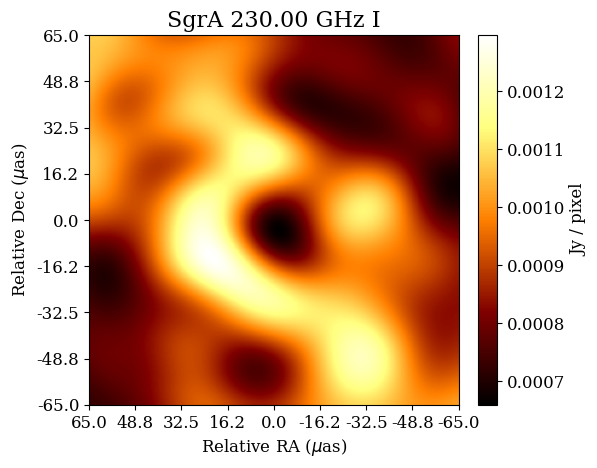

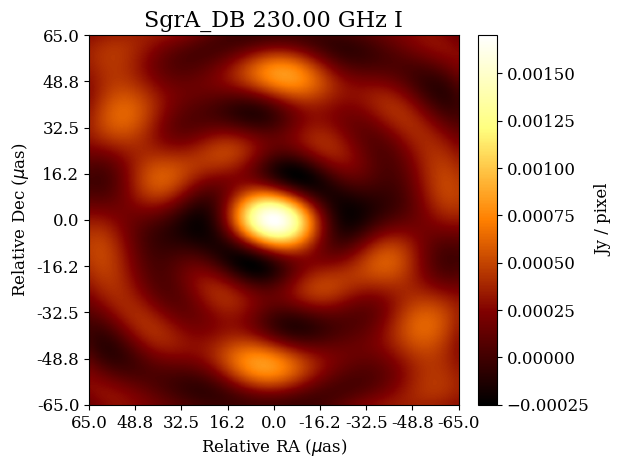

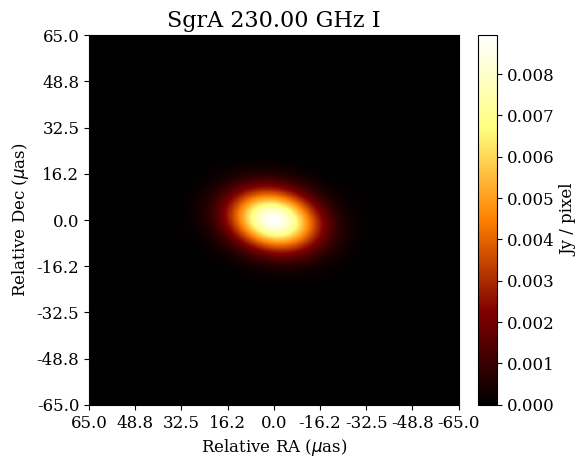

In [709]:
# Plot the dirty image, dirty beam, and clean beam
npix = 64
fov = im.xdim * im.psize

# dirty image
dim = obs.dirtyimage(npix, fov)
dim.display();

# dirty beam
dbeam = obs.dirtybeam(npix, fov)
dbeam.display();

# clean beam
cbeam = obs.cleanbeam(npix,fov)
cbeam.display();

In [710]:
# What is the resolution of the observation? 
beamparams = obs.fit_beam() # fitted beam parameters (fwhm_maj, fwhm_min, theta) in radians
res = obs.res()             # nominal array resolution, 1/longest baseline


print("Clean beam parameters: [%.1f uas,%.1f uas,%.1f deg]"
      %(beamparams[0]/eh.RADPERUAS, beamparams[1]/eh.RADPERUAS,beamparams[2]/eh.DEGREE))
print("Nominal Resolution: %.1f uas"%(res/eh.RADPERUAS))

Clean beam parameters: [24.7 uas,16.3 uas,78.7 deg]
Nominal Resolution: 23.6 uas


## Set  Up and Run an Imager with Complex Visibilities

In [713]:
# Image Parameters
npix = 100
fov = 200*eh.RADPERUAS
zbl = im.total_flux() # total flux
print(zbl)


# Parameters for CLEAN
gain = 0.1  # CLEAN gain (fraction of the peak to subtract in each iteration)
niter = 1000000  # Maximum number of iterations
threshold = 1e-3  # Stopping threshold 

# Initialize the residual image and the clean components
residual = dim.copy()  # Start with the dirty image as the residual
clean_components = eh.image.make_square(obs, npix, fov)  # Empty image for clean components

from scipy.signal import fftconvolve

# CLEAN algorithm implementation
def clean_algorithm(dirty_img, dirty_bm, clean_bm, clean_gain=0.3, stop_threshold=1e-3, max_iterations=10000):
    """
    Execute the Högbom CLEAN algorithm on a dirty image.
    Returns the cleaned image, the model image, and the residual image.
    """
    img_size = int(np.sqrt(dirty_img.imvec.size))
    img_shape = (img_size, img_size)
    model_data = np.zeros_like(dirty_img.imvec)
    residual_data = dirty_img.imvec.copy()
    beam_data = dirty_bm.imvec.reshape(img_shape)

    for _ in range(max_iterations):
        # Locate the peak in the residual
        peak_index = np.argmax(np.abs(residual_data))
        peak_value = residual_data[peak_index]

        if np.abs(peak_value) < stop_threshold:
            break

        # Map the 1D index to a 2D position
        peak_row, peak_col = divmod(peak_index, img_shape[1])

        # Shift the dirty beam to align with the peak position
        shifted_beam = np.roll(np.roll(beam_data, peak_row - img_shape[0] // 2, axis=0),
                               peak_col - img_shape[1] // 2, axis=1)

        # Update the residual and the model
        residual_data -= clean_gain * peak_value * shifted_beam.flatten()
        model_data[peak_index] += clean_gain * peak_value

    # Convert the model data to an image object
    model_img = dirty_img.copy()
    model_img.imvec = model_data

    # Convert the residual data to an image object
    residual_img = dirty_img.copy()
    residual_img.imvec = residual_data

    # Convolve the model with the CLEAN beam
    convolved_model = fftconvolve(model_data.reshape(img_shape), clean_bm.imarr(), mode='same')

    # Add the residuals back to the convolved model
    final_cleaned_img = dirty_img.copy()
    final_cleaned_img.imvec = convolved_model.flatten()

    return final_cleaned_img, model_img, residual_img


4.104371497900001


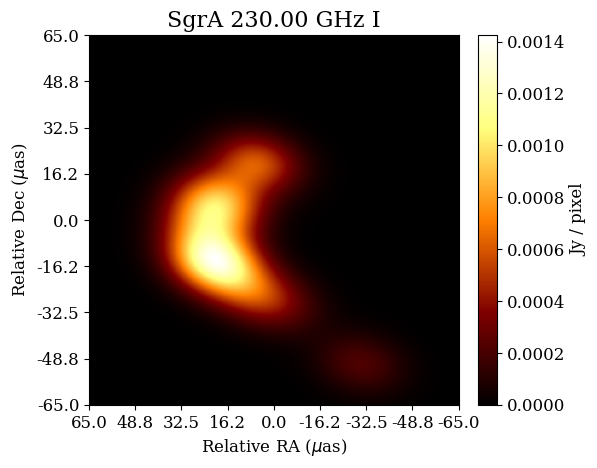

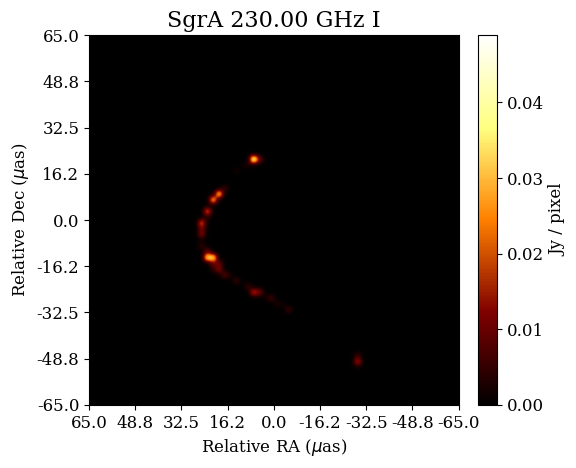

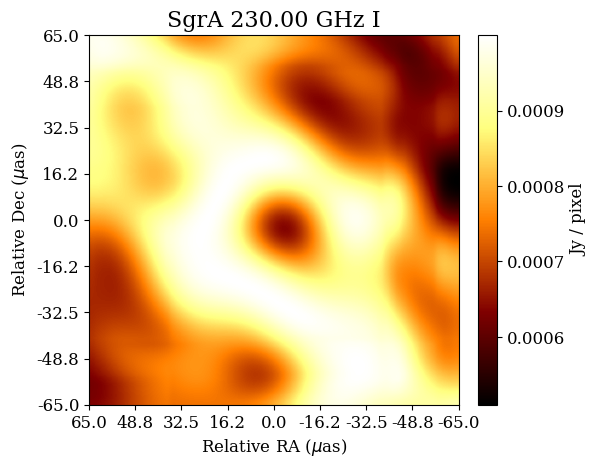

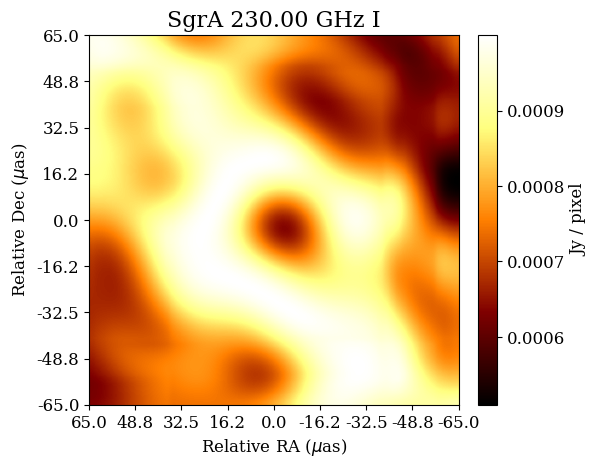

In [714]:
# Run the CLEAN algorithm
clean_image, model_image, residual_image = clean_algorithm(dim, dbeam, cbeam, gain, threshold, niter)

# Display the results
clean_image.display()
model_image.display()
residual_image.display()

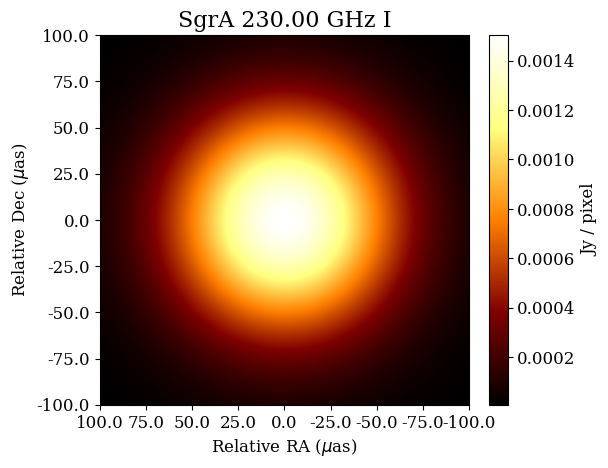

In [125]:
# Set up and display an image prior
prior_fwhm = 100*eh.RADPERUAS # Gaussian size in microarcssec
emptyprior = eh.image.make_square(obs, npix, fov)
flatprior = emptyprior.add_flat(zbl)
gaussprior = emptyprior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))
gaussprior.display();

In [717]:
# Image total flux with amplitude and closure phase
data_term={'vis':1}              # data term weights
#data_term={'vis':1, 'amp': 1, 'cphase': 1, 'logcamp': 1}              # data term weights
reg_term = {'simple': 1, 'tv2': 1, 'tv': 1, 'flux':1, 'l1': 0.1}   # regularizer term weights


# set up the imager
imgr  = eh.imager.Imager(obs, gaussprior, prior_im=gaussprior, flux=zbl,
                         data_term=data_term, reg_term=reg_term, 
                         norm_reg=True, # this is very important!
                         epsilon_tv = 1.e-10,
                         maxit=250, ttype=ttype)

Initializing imager data products . . .


In [718]:
# run the imager
# NOTE: show_updates does not display well in jupyter for some reason
# try using show_updates in a terminal window
# but here we keep show_updates=False for speed
imgr.make_image_I(show_updates=False)

Imager run 1 
Imaging . . .


time: 6.232427 s
J: 5.085917
chi2_vis : 2.87 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


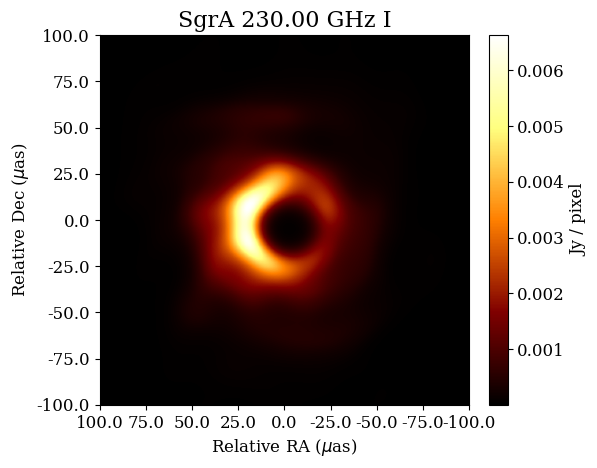

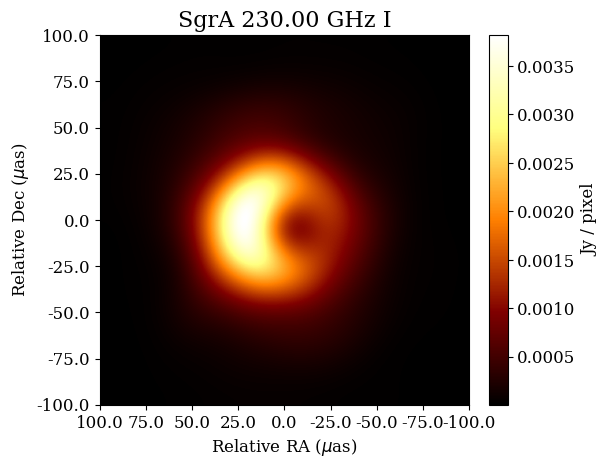

In [715]:
# Display the raw result of the first round
out = imgr.out_last()
out.display()

# Blur the result to the nominal resolution and display
outblur = out.blur_circ(res)
outblur.display();

Imager run 2 
Imaging . . .
time: 4.838438 s
J: 4.463071
chi2_vis : 2.27 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


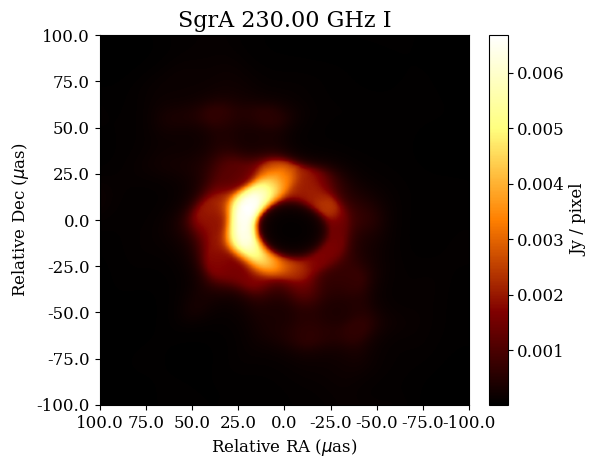

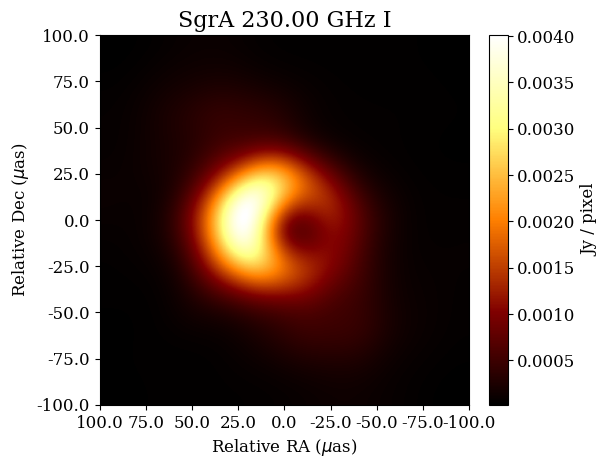

In [719]:
# re-initialize imager with the blurred output of the last round
imgr.init_next = imgr.out_last().blur_circ(res)

# run the imager a second time
imgr.make_image_I(show_updates=False)

# display the output of the second round
out = imgr.out_last()
outblur = out.blur_circ(res)
out.display();
outblur.display();

Imager run 3 
Imaging . . .
time: 8.591233 s
J: 3.514841
chi2_vis : 1.41 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


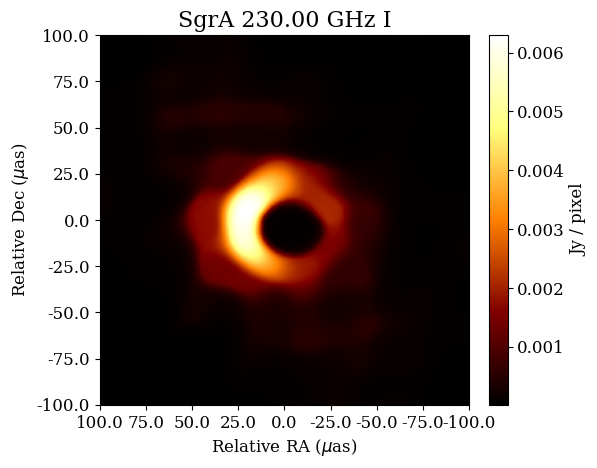

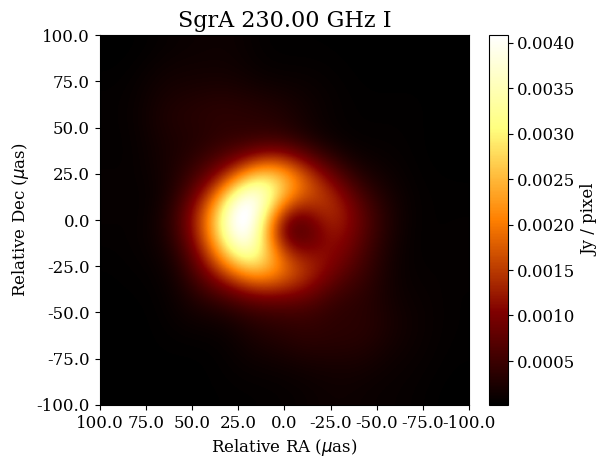

In [720]:
# update the initial image and image one more time
imgr.init_next = imgr.out_last().blur_circ(res) # re-initialze the imager
imgr.maxit_next = 500                           # let the imager run for more iterations this time
imgr.make_image_I(show_updates=False)           # run imager

# display the final output
out = imgr.out_last()
outblur = out.blur_circ(res)
out.display();
outblur.display();

## Set  Up and Run an Imager with Closure Phases and Amplitudes

In [722]:
# Image total flux with closure amplitudes and closure phase
#data_term={'logcamp':1,'cphase':0.5} # data term weights
data_term={'amp':1,'cphase':0.5} # data term weights

#reg_term = {'tv2':1, 'l1':0.1}   # regularizer term weights
reg_term = {'tv2':1, 'l1':0.1}   # regularizer term weights

# set up the imager
imgr  = eh.imager.Imager(obs, gaussprior, prior_im=gaussprior, flux=zbl,
                         data_term=data_term, reg_term=reg_term, 
                         norm_reg=True, # this is very important!
                         epsilon_tv = 1.e-10,
                         maxit=250, ttype=ttype)

# image the first time
imgr.make_image_I(show_updates=False)

# re-initialize and image again
imgr.init_next = imgr.out_last().blur_circ(res)
imgr.make_image_I(show_updates=False)

# image one last time
imgr.init_next = imgr.out_last().blur_circ(res) 
imgr.maxit_next = 500                          
imgr.make_image_I(show_updates=False)           


Initializing imager data products . . .
Imager run 1 
Imaging . . .
time: 7.110060 s
J: 9.386534
chi2_amp : 3.59 chi2_cphase : 13.54 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 2 
Imaging . . .
time: 5.712132 s
J: 7.357663
chi2_amp : 3.33 chi2_cphase : 10.00 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 3 
Imaging . . .
time: 13.426209 s
J: 3.076916
chi2_amp : 2.42 chi2_cphase : 3.30 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


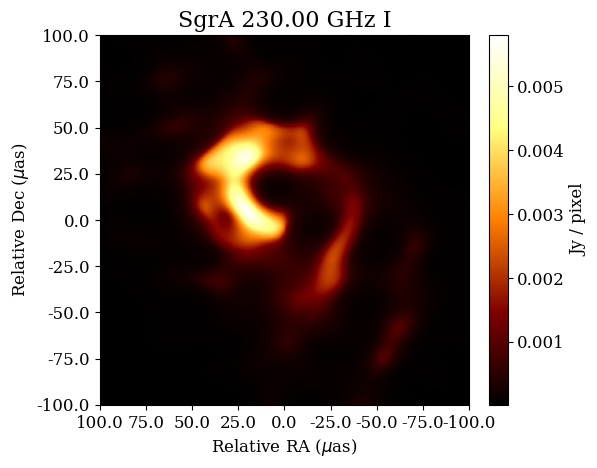

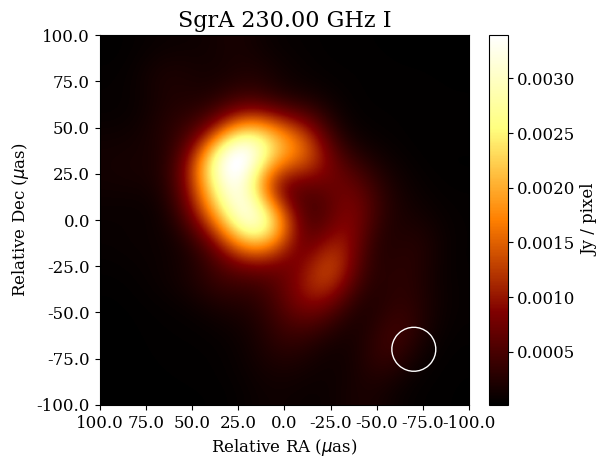

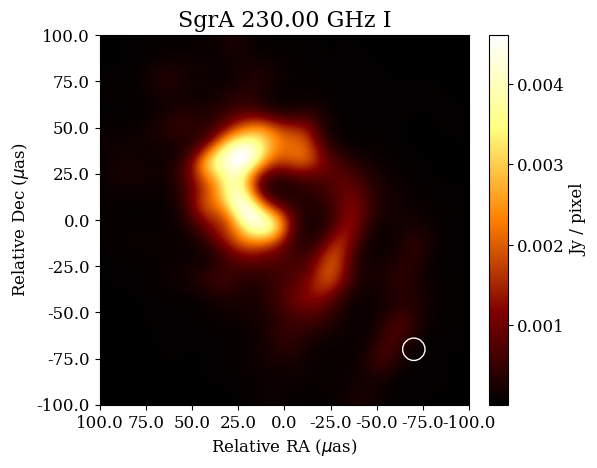

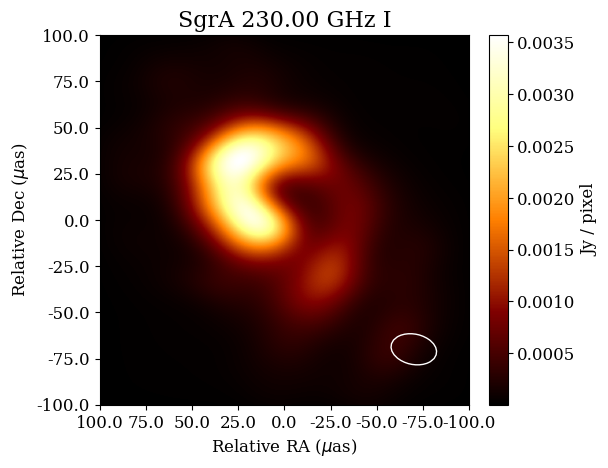

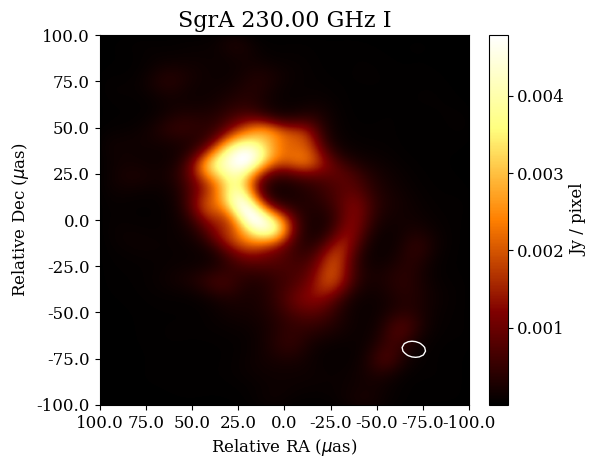

In [723]:
# display the final output at various blur levels
# raw output
out = imgr.out_last()
out.display();

# blurred to the full nominal resolution
outblur1 = out.blur_circ(res) 
outblur1.display(beamparams=[res,res,0]);

# blurred to half the nominal resolution
outblur2 = out.blur_circ(0.5*res) 
outblur2.display(beamparams=[0.5*res,0.5*res,0]);

# blurred to  the asymmetric nominal beam
outblur3 = out.blur_gauss(beamparams) 
outblur3.display(beamparams=beamparams);

# blurred to half the asymmetric nominal beam
beamparams_superres=[0.5*beamparams[0],0.5*beamparams[1],beamparams[2]]
outblur3 = out.blur_gauss(beamparams_superres) 
outblur3.display(beamparams=beamparams_superres);

In [21]:
# save the output
out.save_fits(outpath+'_output.fits')